<a href="https://colab.research.google.com/github/singhtejus/Materials-detection-AI/blob/main/RF_%26_feature_extraction_materials_model_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Material Detection using ML and AI




**By: Tejus Singh**

**Rising Senior at Evergreen Valley High School**





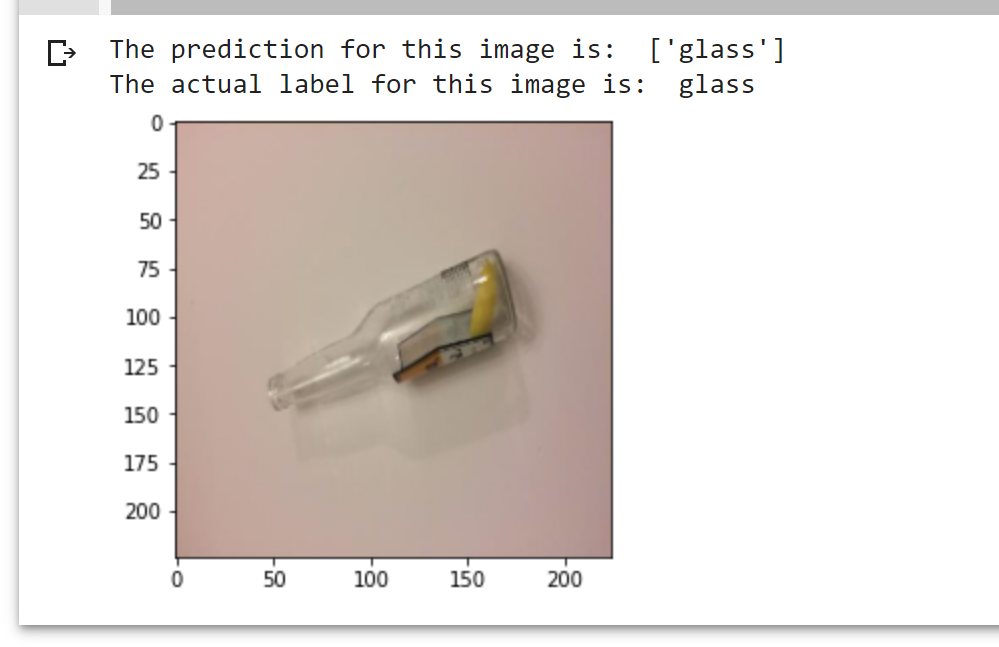

In [ ]:
#@title Import Libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from numpy.random import seed
seed(1337)
import tensorflow
from tensorflow.keras.optimizers import Adam
tensorflow.random.set_seed(42)
from tensorflow.python.keras.applications import vgg16
from tensorflow.python.keras.applications.vgg16 import preprocess_input
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.python.keras.callbacks import ModelCheckpoint
from tensorflow.python.keras import layers, models, Model, optimizers
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import plot_confusion_matrix
import shutil 
import os
from google.colab import files

from google.colab import output
#! mkdir ~/.kaggle #make kaggle directory
#!cp kaggle.json ~/.kaggle/ #copy json file into kaggle folder
#!chmod 600 ~/.kaggle/kaggle.json #give permissions

#!kaggle datasets download -d asdasdasasdas/garbage-classification
#!unzip garbage-classification.zip 
from google.colab import drive
drive.mount('/content/drive')

output.clear()

In [ ]:
#@title Import Dataset
!cd /content/drive/MyDrive
!cp -av '/content/drive/MyDrive/Materials Dataset' '/content/Materials Dataset Copy'

In [ ]:
#@title Put Data into Train and Validation Sets
import cv2
#make val and train folders
os.mkdir('/content/Materials Dataset Copy/Materials/train')
os.mkdir('/content/Materials Dataset Copy/Materials/validation')

labels = ['cardboard', 'glass', 'metal', 'paper', 'plastic']
base_directory = '/content/Materials Dataset Copy/Materials'
train_dir = '/content/Materials Dataset Copy/Materials/train'
validation_dir = '/content/Materials Dataset Copy/Materials/validation'

for label in labels:
  os.mkdir(os.path.join(train_dir,label))
  os.mkdir(os.path.join(validation_dir,label))



for label in labels:
  img_folder = os.path.join(base_directory,label) #select labeled bucket
  #print(img_folder)
  filelist = os.listdir(img_folder) #creates list out of bucket items
  
  total_len = len(filelist)
  train_amount = int(0.9*total_len)

  count = 0
  #put 90% of labeled images into train and 10% of labeled images into validation
  for item in filelist: 
      source = os.path.join(base_directory,label,item)
      
      if count < train_amount:
        destination = os.path.join(train_dir,label,item)
        shutil.move(source,destination)
      else:
        destination = os.path.join(validation_dir,label,item)
        shutil.move(source,destination)
        
      count += 1
shutil.rmtree('/content/Materials Dataset Copy/Materials/cardboard')
shutil.rmtree('/content/Materials Dataset Copy/Materials/glass')
shutil.rmtree('/content/Materials Dataset Copy/Materials/metal')
shutil.rmtree('/content/Materials Dataset Copy/Materials/paper')
shutil.rmtree('/content/Materials Dataset Copy/Materials/plastic')

In [ ]:
#@title Convert Train Images to Array and put into Final List
SIZE = 224
train_images = []
train_labels =[]
train = "train"
trained_folder = os.path.join(base_directory,train)

for label in labels:
  filelist = os.path.join(trained_folder, label)
  #print(filelist)
  file_list = os.listdir(filelist) #creates list out of bucket items 
  for item in file_list:
    img_path = os.path.join(filelist,item)
    img = cv2.imread(img_path, cv2.IMREAD_COLOR)       
    img = cv2.resize(img, (SIZE, SIZE))
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    train_images.append(img)
    train_labels.append(label)

train_images = np.array(train_images)
train_labels = np.array(train_labels)

In [ ]:
#@title Convert Train Images to Array and put into Final List
test_images = []
test_labels = [] 
test = "validation"
test_folder = os.path.join(base_directory,test)
for label in labels:
  filelist = os.path.join(test_folder, label)
  file_list = os.listdir(filelist) #creates list out of bucket items 
  for item in file_list:
    img_path = os.path.join(filelist,item)
    img = cv2.imread(img_path, cv2.IMREAD_COLOR)
    img = cv2.resize(img, (SIZE, SIZE))
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    test_images.append(img)
    test_labels.append(label)

#Convert lists to arrays                
test_images = np.array(test_images)
test_labels = np.array(test_labels)

In [ ]:
#@title Convert Labels to Array
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(test_labels)
test_labels_encoded = le.transform(test_labels)
le.fit(train_labels)
train_labels_encoded = le.transform(train_labels)

x_train, y_train, x_test, y_test = train_images, train_labels_encoded, test_images, test_labels_encoded

In [ ]:
#@title Normalize Data so values fit within 0-1

from tensorflow.keras.utils import to_categorical
x_train, x_test = x_train / 255.0, x_test / 255.0

y_train_one_hot = to_categorical(y_train)
y_test_one_hot = to_categorical(y_test)

In [ ]:
#@title Initiate VGG16 Feature Extraction Model

from keras.applications.vgg16 import VGG16
VGG_model = VGG16(weights='imagenet', include_top=False, input_shape=(SIZE, SIZE, 3))

#Make loaded layers as non-trainable. This is important as we want to work with pre-trained weights
for layer in VGG_model.layers:
	layer.trainable = False
    
VGG_model.summary()  #Trainable parameters will be 0


#Now, let us use features from convolutional network for RF
feature_extractor=VGG_model.predict(x_train)

features = feature_extractor.reshape(feature_extractor.shape[0], -1)

X_for_RF = features #This is our X input to RF


58900480/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
______________________________________________________________

In [ ]:
#@title Convert Train Images to Array and put into Final List

from sklearn.ensemble import RandomForestClassifier
RF_model = RandomForestClassifier(n_estimators = 50, random_state = 42)

# Train the model on training data
RF_model.fit(X_for_RF, y_train) #For sklearn no one hot encoding

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=50,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [ ]:
#@title Pull Features from the Test Images
X_test_feature = VGG_model.predict(x_test)
X_test_features = X_test_feature.reshape(X_test_feature.shape[0], -1)

#Now predict using the trained RF model. 
prediction_RF = RF_model.predict(X_test_features)
#Inverse le transform to get original label back. 
prediction_RF = le.inverse_transform(prediction_RF)

Accuracy =  0.7087719298245614


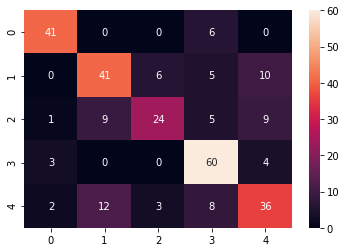

In [ ]:
#@title How Accurate is my Model?
from sklearn import metrics
print ("Accuracy = ", metrics.accuracy_score(test_labels, prediction_RF))

#Confusion Matrix - verify accuracy of each class
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(test_labels, prediction_RF)
#print(cm)
sns.heatmap(cm, annot=True)


In [1]:
#@title Test on Random Images
n=np.random.randint(0, x_test.shape[0])
img = x_test[n]
plt.imshow(img)
input_img = np.expand_dims(img, axis=0) #Expand dims so the input is (num images, x, y, c)
input_img_feature=VGG_model.predict(input_img)
input_img_features=input_img_feature.reshape(input_img_feature.shape[0], -1)
prediction_RF = RF_model.predict(input_img_features)[0] 
prediction_RF = le.inverse_transform([prediction_RF])  #Reverse the label encoder to original name
print("The prediction for this image is: ", prediction_RF)
#print("The actual label for this image is: ", test_labels[n])

NameError: ignored

In [ ]:
#@title Save RandomForest Classifier model
import joblib
joblib.dump(RF_model, "RF_model_2")